In [37]:
library(tidyverse)
# imports for the distributed combat
library(matrixStats)
source("https://raw.githubusercontent.com/andy1764/Distributed-ComBat/main/distributedCombat.R")
source("https://raw.githubusercontent.com/andy1764/Distributed-ComBat/main/neuroCombat.R")
source("https://raw.githubusercontent.com/andy1764/Distributed-ComBat/main/neuroCombat_helpers.R")


# Running Distributed ComBat - [dComBat](https://github.com/andy1764/Distributed-ComBat)

for simulated data. Data don't contain NA values.

Based on dComBat readme:

```
You will need the following variables:
  - dat: features x subject data matrix for this site
  - bat: batch identifiers, needs to have same factor levels across sites
  - mod: covariates to protect in the data, usually output of stats:model.matrix
```

# Step 1: LOCAL: Local params calculation
Prepare data and do the first step - local params calculation

In [38]:
data <- list()
design <- list()
batches <- list()

for_central_intensities <- list()
for_central_metadata <- list()

time_tracked <- list()

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    data[[mode]] <- list()
    design[[mode]] <- list()
    batches[[mode]] <- list()

    for_central_intensities[[mode]] <- NULL
    for_central_metadata[[mode]] <- NULL

    time_tracked[[mode]] <- list()

    for(lab in c("lab1", "lab2", "lab3")){

        path_to_data <- paste0("../../evaluation_data/simulated/", mode, "/before/", lab, "/")
        
        dat <- read.csv(paste0(path_to_data, "intensities.tsv"), sep = "\t", row.names=1) %>%
                as.data.frame()
        metadata <- read.csv(paste0(path_to_data, "design.tsv"), sep = "\t") %>%
                as.data.frame()

        if (is.null(for_central_metadata[[mode]])){
            for_central_metadata[[mode]] <- metadata
            for_central_intensities[[mode]] <- dat %>% rownames_to_column("rowname")
        } else {
            for_central_metadata[[mode]] <- rbind(for_central_metadata[[mode]], metadata)
            for_central_intensities[[mode]] <- full_join(for_central_intensities[[mode]], dat %>% rownames_to_column("rowname"), by = "rowname")
        }

        mod <- model.matrix(~0 + metadata$condition)
        rownames(mod) <- metadata$file
        colnames(mod) <- levels(as.factor(metadata$condition))
        mod <- mod %>% as.data.frame() %>% select(B) %>% as.matrix()
        bat <- factor(metadata$lab, levels = c("lab1", "lab2", "lab3"))

        # dat <- t(dat) 
        dat <- dat[, metadata$file] %>% as.matrix()

        # time tracking
        time_tracked[[mode]][[lab]] <- proc.time()

        # d-ComBat 1st step
        distributedCombat_site(dat, bat, mod, 
            file = paste0("intermediate data/", mode, "_", lab, "_step1.Rdata")
        )
        
        # time tracking
        end_time <- proc.time()
        time_tracked[[mode]][[lab]] <- end_time - time_tracked[[mode]][[lab]]

        data[[mode]][[lab]] <- dat
        design[[mode]][[lab]] <- mod
        batches[[mode]][[lab]] <- bat

        print(paste0("Saved corrected intensities for mode: intermediate data/", mode, "_", lab, "_step1.Rdata"))

        print(paste0("Saved corrected intensities for mode: ", mode))

    }

    for_central_intensities[[mode]] <- for_central_intensities[[mode]] %>%
        column_to_rownames("rowname") %>%
        .[, for_central_metadata[[mode]]$file]

    
    print(paste0("For central data dimensions: ", dim(for_central_intensities[[mode]])))
}

[1] "Processing mode: balanced"
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[1] "Saved corrected intensities for mode: intermediate data/balanced_lab1_step1.Rdata"
[1] "Saved corrected intensities for mode: balanced"
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[1] "Saved corrected intensities for mode: intermediate data/balanced_lab2_step1.Rdata"
[1] "Saved corrected intensities for mode: balanced"
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[1] "Saved corrected intensities for mode: intermediate data/balanced_lab3_step1.Rdata"
[1] "Saved corrected intensities for mode: balanced"
[1] "For central data dimensions: 6000" "For central data dimensions: 600" 
[1] "Processing mode: mild_imbalanced"
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[1] "Saved corrected intensities for mode: intermediate data/mild_imbalanced_lab1_

# Step 2: CENTRAL: Aggregate local parameters

In [39]:
for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    time_tracked[[mode]][["central"]] <- proc.time()

    distributedCombat_central(c(
            paste0("intermediate data/", mode, "_lab1_step1.Rdata"),
            paste0("intermediate data/", mode, "_lab2_step1.Rdata"),
            paste0("intermediate data/", mode, "_lab3_step1.Rdata")), 
        file = paste0("intermediate data/", mode, "_central_step1.Rdata")
    )
    
    end_time <- proc.time()
    time_tracked[[mode]][["central"]] <- end_time - time_tracked[[mode]][["central"]]

}

[1] "Processing mode: balanced"
[1] "Processing mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"


# STEP 3: LOCAL get summary statistics for sigma estimation

In [40]:
for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    for(lab in c("lab1", "lab2", "lab3")){

        time_start <- proc.time()

        dat <- data[[mode]][[lab]]
        mod <- design[[mode]][[lab]]
        bat <- batches[[mode]][[lab]]

        distributedCombat_site(dat, bat, mod,
            file = paste0("intermediate data/", mode, "_", lab, "_step2.Rdata"),
            central.out = paste0("intermediate data/", mode, "_central_step1.Rdata")
        )

        end_time <- proc.time()
        time_tracked[[mode]][[lab]] <- time_tracked[[mode]][[lab]] + (end_time - time_start)
    }
    print(paste0("Processed step 2 for mode: ", mode))
}

[1] "Processing mode: balanced"
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[1] "Processed step 2 for mode: balanced"
[1] "Processing mode: mild_imbalanced"
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[1] "Processed step 2 for mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[1] "Processed

# STEP 4: CENTRAL: FINAL AGGREGATION

In [41]:
for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    time_start <- proc.time()

    distributedCombat_central(c(
            paste0("intermediate data/", mode, "_lab1_step2.Rdata"),
            paste0("intermediate data/", mode, "_lab2_step2.Rdata"),
            paste0("intermediate data/", mode, "_lab3_step2.Rdata")), 
        file = paste0("intermediate data/", mode, "_central_step2.Rdata")
    )

    end_time <- proc.time()
    time_tracked[[mode]][["central"]] <- time_tracked[[mode]][["central"]] + (end_time - start_time)

}

[1] "Processing mode: balanced"
[1] "Processing mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"


# STEP 5: LOCAL: APPLY CORRECTION

In [42]:
corrected_data <- list()

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    corrected_data[[mode]] <- NULL
    for(lab in c("lab1", "lab2", "lab3")){

        dat <- data[[mode]][[lab]]
        mod <- design[[mode]][[lab]]
        bat <- batches[[mode]][[lab]]

        start_time <- proc.time()

        corrected_data_ind <- distributedCombat_site(dat, bat, mod,
            central.out = paste0("intermediate data/", mode, "_central_step2.Rdata")
        )$dat.combat %>% as.data.frame() %>% rownames_to_column("rowname")

        end_time <- proc.time()
        time_tracked[[mode]][[lab]] <- time_tracked[[mode]][[lab]] + (end_time - start_time)

        if (is.null(corrected_data[[mode]])){
            corrected_data[[mode]] <- corrected_data_ind
        } else {
            corrected_data[[mode]] <- full_join(corrected_data[[mode]], corrected_data_ind, by = "rowname")
        }
        
    }

    corrected_data[[mode]] <- corrected_data[[mode]] %>% column_to_rownames("rowname")

    print(paste0("Processed step 2 for mode: ", mode))
}

[1] "Processing mode: balanced"


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data
[1] "Processed step 2 for mode: balanced"
[1] "Processing mode: mild_imbalanced"


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data
[1] "Processed step 2 for mode: mild_imbalanced"
[1] "Processing mode: strong_imbalanced"


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data


Warning message in distributedCombat_site(dat, bat, mod, central.out = paste0("intermediate data/", :
“Must specify filename to output results as a file. Currently
            saving output to current workspace only.”


[combat] Found 3 batches
[combat] Adjusting for  1  covariate(s) or covariate level(s)
[distributedCombat] Fitting L/S model and finding priors
[distributedCombat] Finding parametric adjustments
[distributedCombat] Adjusting the Data
[1] "Processed step 2 for mode: strong_imbalanced"


In [43]:
# Time tracking

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    print(paste0("Time tracked for central, s: ", round(time_tracked[[mode]][["central"]][["elapsed"]], 1)))    
    print("")
}

[1] "Processing mode: balanced"
[1] "Time tracked for central, s: 400.4"
[1] ""
[1] "Processing mode: mild_imbalanced"
[1] "Time tracked for central, s: 401.8"
[1] ""
[1] "Processing mode: strong_imbalanced"
[1] "Time tracked for central, s: 403.3"
[1] ""


In [44]:
# Time tracking

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    # print(paste0("Time tracked for central: "))
    # print(time_tracked[[mode]][["central"]])
    print(paste0("Time tracked for lab1, ms: ", round(time_tracked[[mode]][["lab1"]][["elapsed"]] * 1000, 2)))
    print(paste0("Time tracked for lab2: ms: ", round(time_tracked[[mode]][["lab2"]][["elapsed"]] * 1000, 2)))
    print(paste0("Time tracked for lab3: ms: ", round(time_tracked[[mode]][["lab3"]][["elapsed"]] * 1000, 2)))

    print("")
}

[1] "Processing mode: balanced"
[1] "Time tracked for lab1, ms: 1073"
[1] "Time tracked for lab2: ms: 1518"
[1] "Time tracked for lab3: ms: 1313"
[1] ""
[1] "Processing mode: mild_imbalanced"
[1] "Time tracked for lab1, ms: 848"
[1] "Time tracked for lab2: ms: 1538"
[1] "Time tracked for lab3: ms: 1114"
[1] ""
[1] "Processing mode: strong_imbalanced"
[1] "Time tracked for lab1, ms: 661"
[1] "Time tracked for lab2: ms: 632"
[1] "Time tracked for lab3: ms: 1418"
[1] ""


# Central correction with ComBat sva

In [8]:
library(tidyverse)
library(patchwork)
source("/home/yuliya/repos/other/removeBatch/evaluation_utils/plots_eda.R")
source("/home/yuliya/repos/other/removeBatch/evaluation_utils/evaluation_funcs.R")


library(sva)

In [9]:
combat_res <- list()

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    dat <- for_central_intensities[[mode]]
    metadata <- for_central_metadata[[mode]] %>% 
        mutate(lab = factor(lab, levels = c("lab1", "lab2", "lab3")))

    dat <- dat %>% as.data.frame()
    dat <- dat[, metadata$file]

    design <- model.matrix(~metadata$condition)

    combat_res[[mode]] <- ComBat(dat=dat, 
                                 batch=metadata$lab, mod=design)
}

[1] "Processing mode: balanced"


Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




[1] "Processing mode: mild_imbalanced"


Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




[1] "Processing mode: strong_imbalanced"


Found3batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




# Plots and comparison with central ComBat

In [10]:
cbPalette <- c("#CC79A7", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00")

In [11]:
# supress warnings
options(warn=-1)

In [12]:
for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
)){
    print(paste("Mode:", mode))
    differences <- calculated_differences(
        combat_res[[mode]], 
        corrected_data[[mode]]
    )
    cat("Min difference:", differences[2], "\n")
    cat("Mean difference:", differences[3], "\n")
    cat("Max difference:", differences[1], "\n")
    
    cat("\n")
}

[1] "Mode: balanced"
Min difference: 0 
Mean difference: 5.34464e-16 
Max difference: 1.421085e-14 

[1] "Mode: mild_imbalanced"
Min difference: 0 
Mean difference: 7.823573e-16 
Max difference: 1.421085e-14 

[1] "Mode: strong_imbalanced"
Min difference: 0 
Mean difference: 4.600247e-16 
Max difference: 2.131628e-14 



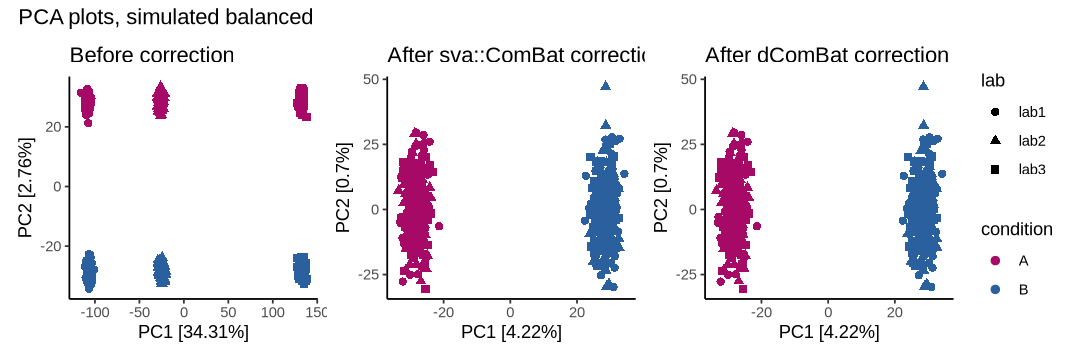

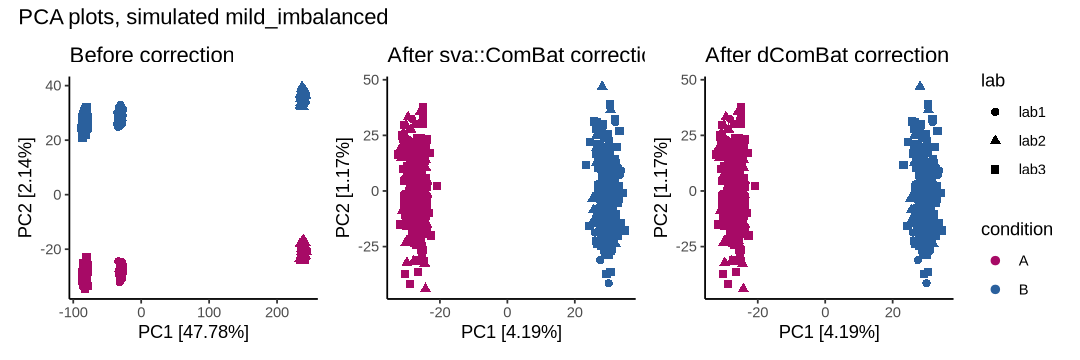

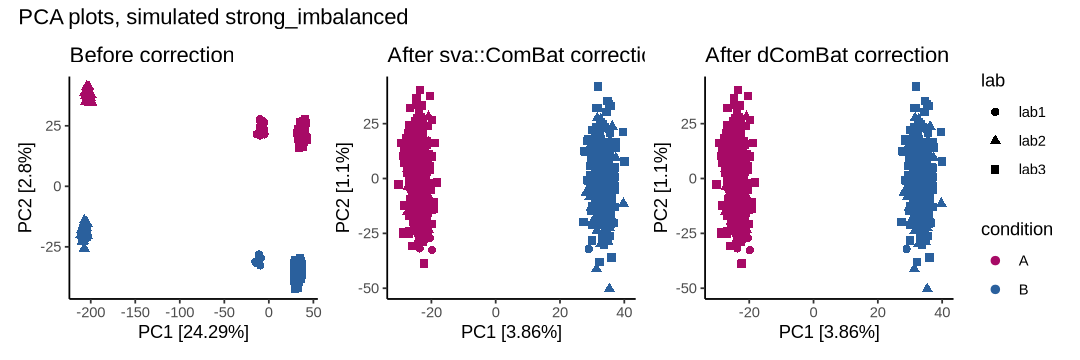

In [12]:
plot_pca_uncorrected <- list()
plot_pca_SVAcorrected <- list()
plot_pca_FEDcorrected <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
 )){
    plot_pca_uncorrected[[mode]] <- pca_plot(
        for_central_intensities[[mode]], 
        for_central_metadata[[mode]],
        title = paste("Before correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=F, cbPalette=c("#a70a66", "#2a609d"))

    plot_pca_SVAcorrected[[mode]] <- pca_plot(
        combat_res[[mode]], 
        for_central_metadata[[mode]],
        title = paste("After sva::ComBat correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=F, cbPalette=c("#a70a66", "#2a609d"))

    plot_pca_FEDcorrected[[mode]] <- pca_plot(
        corrected_data[[mode]], 
        for_central_metadata[[mode]],
        title = paste("After dComBat correction"),
        quantitative_col_name = "file", 
        col_col = "condition", shape_col="lab", show_legend=T, cbPalette=c("#a70a66", "#2a609d"))


    layout <- plot_pca_uncorrected[[mode]] + plot_pca_SVAcorrected[[mode]] + plot_pca_FEDcorrected[[mode]]
    layout <- layout + plot_annotation(paste0("PCA plots, simulated ", mode))
    options(repr.plot.width=9, repr.plot.height=3)
    print(layout)
}



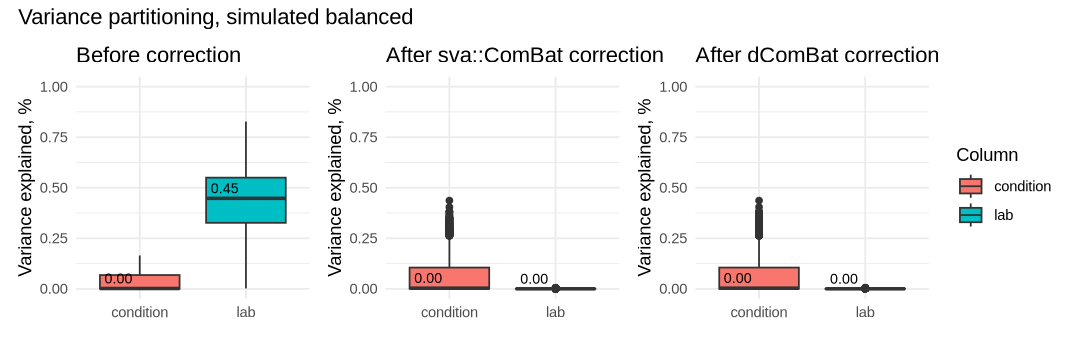

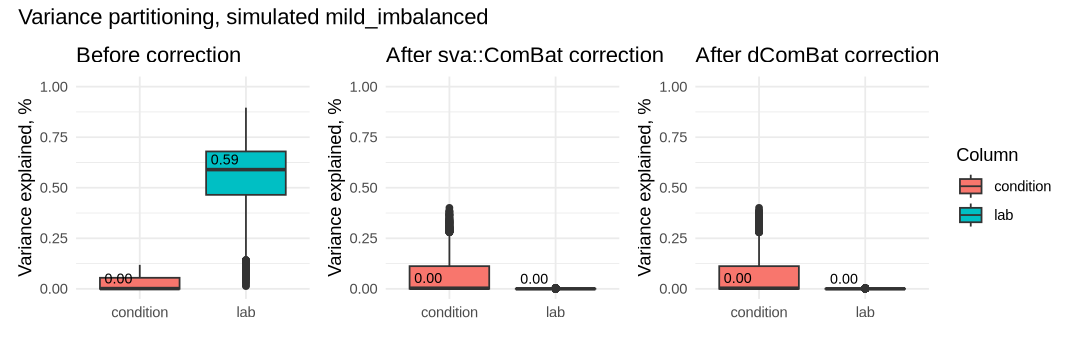

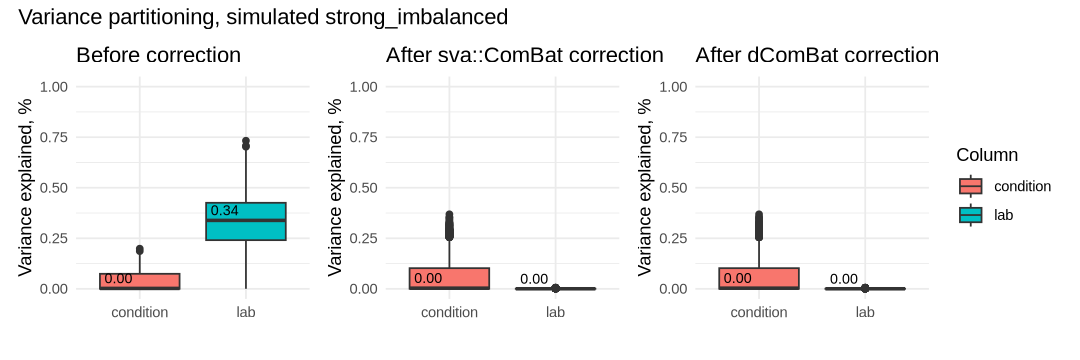

In [13]:
form <- ~ condition + lab

y_limits_values <- list(
    "balanced" = 0.51,
    "mild_imbalanced" = 0.62,
    "strong_imbalanced" = 0.6
)

lmpv_plot_uncorrected <- list()
lmpv_plot_fed <- list()
lmpv_plot_sva <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
)){

    lmpv_plot_uncorrected[[mode]] <- lmpv_plot(
        for_central_intensities[[mode]], 
        for_central_metadata[[mode]], 
        paste("Before correction"), show_legend=F, 
        # max_yval = y_limits_values[[mode]],
        form = form)

    lmpv_plot_sva[[mode]] <- lmpv_plot(
        combat_res[[mode]], 
        for_central_metadata[[mode]], 
        paste("After sva::ComBat correction"), show_legend=F,
        # max_yval = y_limits_values[[mode]],
        form = form)

    lmpv_plot_fed[[mode]] <- lmpv_plot(
        corrected_data[[mode]], 
        for_central_metadata[[mode]], 
        paste("After dComBat correction"), 
        # max_yval = y_limits_values[[mode]],
        form = form)

    layout <- lmpv_plot_uncorrected[[mode]] |  lmpv_plot_sva[[mode]] | lmpv_plot_fed[[mode]]
    layout <- layout + plot_annotation(paste0("Variance partitioning, simulated ", mode))
    options(repr.plot.width=9, repr.plot.height=3)
    print(layout)
}


# Compare with fedRBE results

In [13]:
fedrbe_corrected <- list()

for (mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
    )){
    print(paste0("Processing mode: ", mode))

    fedrbe_corrected[[mode]] <- read.table(
            paste0("../../evaluation_data/simulated/", mode, "/after/FedSim_corrected_data.tsv"),
            sep = "\t", header = T, row.names = 1
        ) %>%
        as.data.frame() 

    fedrbe_corrected[[mode]] <- fedrbe_corrected[[mode]][rownames(corrected_data[[mode]]), for_central_metadata[[mode]]$file]

    differences <- calculated_differences(
        fedrbe_corrected[[mode]], 
        corrected_data[[mode]]
    )
    cat("Min difference:", differences[2], "\n")
    cat("Mean difference:", differences[3], "\n")
    cat("Max difference:", differences[1], "\n")

    cat("\n")
}


[1] "Processing mode: balanced"
Min difference: 1.856735e-08 
Mean difference: 0.04114225 
Max difference: 1.422 

[1] "Processing mode: mild_imbalanced"
Min difference: 0.0001096857 
Mean difference: 0.532838 
Max difference: 2.152108 

[1] "Processing mode: strong_imbalanced"
Min difference: 9.817888e-06 
Mean difference: 0.7689446 
Max difference: 4.439685 



[1] "Mode: balanced"


`geom_smooth()` using formula = 'y ~ x'


[1] "Mode: mild_imbalanced"


`geom_smooth()` using formula = 'y ~ x'


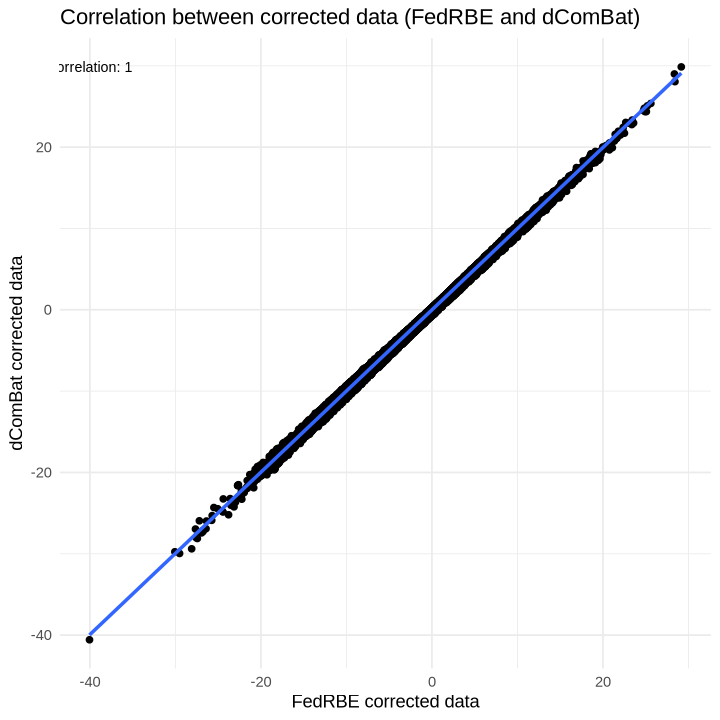

[1] "Mode: strong_imbalanced"


`geom_smooth()` using formula = 'y ~ x'


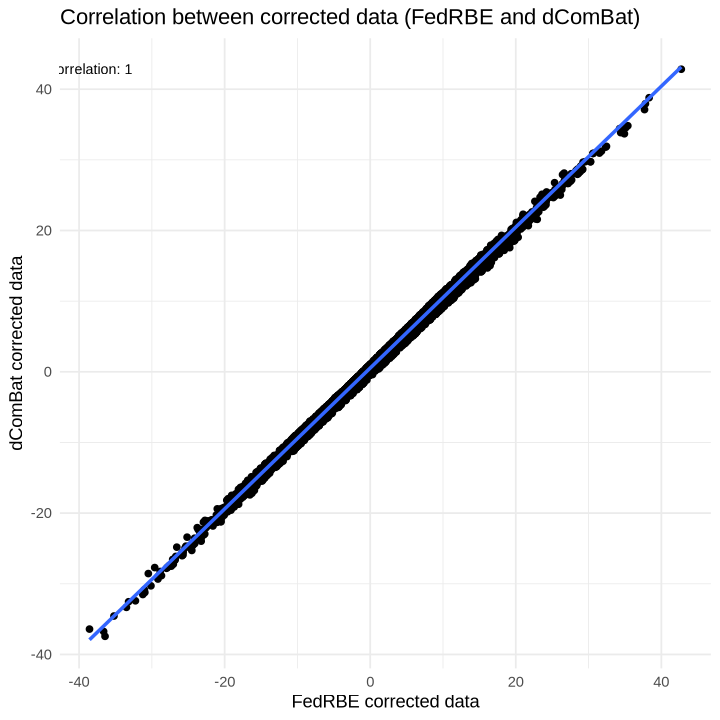

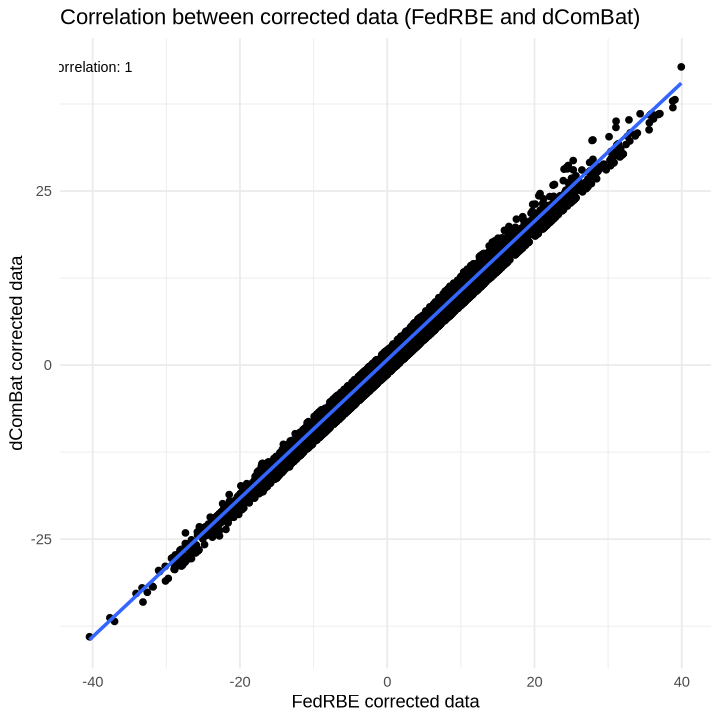

In [14]:
# plot correlations between corrected data  - fedrbe_corrected and corrected_data
for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
 )){
    print(paste("Mode:", mode))
    plot <- ggplot(
        data = data.frame(
            x = as.vector(as.matrix(fedrbe_corrected[[mode]])),
            y = as.vector(as.matrix(corrected_data[[mode]]))
        ),
        aes(x = x, y = y)
    ) +
    geom_point() +
    geom_smooth(method = "lm") +
    labs(title = paste("Correlation between corrected data (FedRBE and dComBat)"),
         x = "FedRBE corrected data", y = "dComBat corrected data") +
    theme_minimal()

    # add correlation coefficient on the plot (upper left corner)
    cor_val <- round(cor(as.vector(as.matrix(fedrbe_corrected[[mode]])), as.vector(as.matrix(corrected_data[[mode]]))), 2)
    plot <- plot + 
        annotate("text", 
                x = min(as.vector(as.matrix(fedrbe_corrected[[mode]]))), 
                y = max(as.vector(as.matrix(corrected_data[[mode]])), na.rm = T), 
                label = paste("Correlation:", cor_val), size = 3)

    options(repr.plot.width=6, repr.plot.height=6)
    print(plot)

}

# Compare with data before introdusing batch effects

In [14]:
data_before_batcheffects <- list()

for(mode in c("balanced", "mild_imbalanced", "strong_imbalanced"
 )){
    data_before_batcheffects[[mode]] <- read.table(
            paste0("../../evaluation_data/simulated/", mode, "/before/intermediate/1_intensities_data_no_batch.tsv"),
            sep = "\t", header = T, row.names = 1
        ) %>%
        as.data.frame()

    data_before_batcheffects[[mode]] <- data_before_batcheffects[[mode]][rownames(corrected_data[[mode]]), for_central_metadata[[mode]]$file]


    print(paste("Mode:", mode))
    print(paste("Differences with fedRBE corrected data:"))
    differences <- calculated_differences(
        fedrbe_corrected[[mode]], 
        data_before_batcheffects[[mode]]
    )
    cat("Min difference:", differences[2], "\n")
    cat("Mean difference:", differences[3], "\n")
    cat("Max difference:", differences[1], "\n")
    cat("\n")

    print(paste("Differences with dComBat corrected data:"))
    differences <- calculated_differences(
        corrected_data[[mode]], 
        data_before_batcheffects[[mode]]
    )
    cat("Min difference:", differences[2], "\n")
    cat("Mean difference:", differences[3], "\n")
    cat("Max difference:", differences[1], "\n")
    cat("\n")

}

[1] "Mode: balanced"
[1] "Differences with fedRBE corrected data:"
Min difference: 2.497048e-06 
Mean difference: 0.6197345 
Max difference: 2.824617 

[1] "Differences with dComBat corrected data:"
Min difference: 6.331749e-07 
Mean difference: 0.6255286 
Max difference: 2.718442 

[1] "Mode: mild_imbalanced"
[1] "Differences with fedRBE corrected data:"
Min difference: 1.789739e-07 
Mean difference: 0.2561521 
Max difference: 3.063212 

[1] "Differences with dComBat corrected data:"
Min difference: 1.658952e-08 
Mean difference: 0.6308054 
Max difference: 3.601146 

[1] "Mode: strong_imbalanced"
[1] "Differences with fedRBE corrected data:"
Min difference: 9.794251e-08 
Mean difference: 0.5377618 
Max difference: 3.807875 

[1] "Differences with dComBat corrected data:"
Min difference: 2.485138e-08 
Mean difference: 0.4444053 
Max difference: 4.706094 



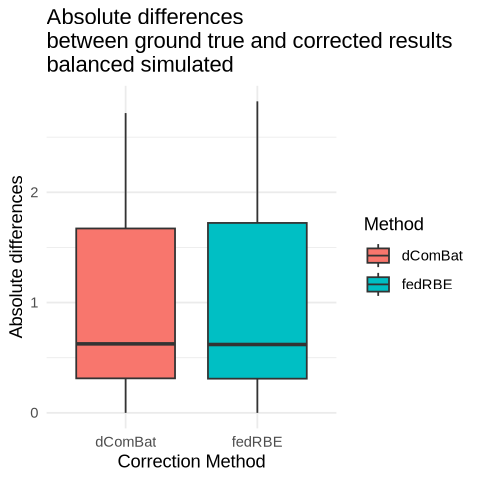

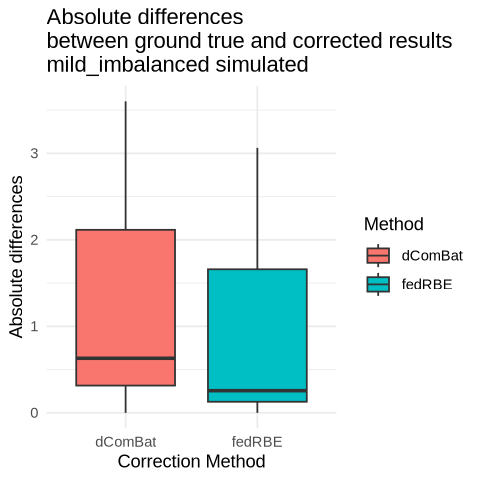

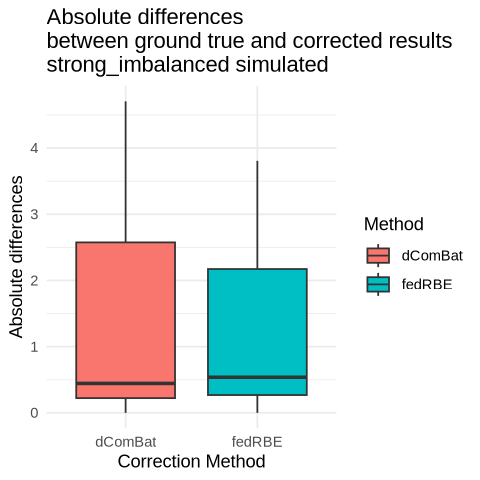

In [22]:
# Define the scenarios
scenarios <- c("balanced", "mild_imbalanced", "strong_imbalanced")

# Initialize a list to store absolute differences
abs_differences_list <- list()

# Calculate absolute differences for each scenario
for (mode in scenarios) {
    # Calculate absolute differences for fedRBE
    fedrbe_differences <- abs(calculated_differences(fedrbe_corrected[[mode]], data_before_batcheffects[[mode]]))
    
    # Calculate absolute differences for dComBat
    dcombat_differences <- abs(calculated_differences(corrected_data[[mode]], data_before_batcheffects[[mode]]))
    
    # Combine the differences in a data frame for plotting
    abs_differences <- data.frame(
        Method = rep(c("fedRBE", "dComBat"), each = length(fedrbe_differences)),
        Differences = c(fedrbe_differences, dcombat_differences)
    )
    
    # Store in the list
    abs_differences_list[[mode]] <- abs_differences
}

# Plotting
for (mode in scenarios) {
    # Create a boxplot for the scenario
    plot <- ggplot(abs_differences_list[[mode]], aes(x = Method, y = Differences, fill = Method)) +
        geom_boxplot() +
        labs(title = paste0("Absolute differences \nbetween ground true and corrected results \n", mode, " simulated"),
             x = "Correction Method",
             y = "Absolute differences") +
        theme_minimal()
    
    # Display the plot
    options(repr.plot.width=4, repr.plot.height=4)
    print(plot)
}
